# Variography

In this preamble, we load the **gstlearn** library.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import gstlearn as gl
import gstlearn.plot as gp
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request

Then the necessary data set is downloaded and named **dat**: the target variable is **January_temp**

In [3]:
url = 'https://soft.minesparis.psl.eu/gstlearn/data/Scotland/Scotland_Temperatures.NF'
temp_nf, head = urllib.request.urlretrieve(url)
dat = gl.Db.createFromNF(temp_nf)

## Experimental variogram

Data is a *regionalized* variable

$$z_i = z(x_i)$$

The experimental variogram is a (discrete) function:

$$\gamma(h)=\frac{1}{2N(h)}\sum_{i=1}^{N(h)}[z(x_i+h)-z(x_i)]^2$$

where $N(h)$ is the number of pairs of points distant by $h$



### Variogram Cloud

In [33]:
varioParamOmni = gl.VarioParam.createOmniDirection(50,2)
grid_cloud = gl.db_variogram_cloud(dat, varioParamOmni)
grid_cloud


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 4
Maximum Number of UIDs       = 4
Total number of samples      = 10000

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :      7.789     0.068
Number :        100       100

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = Cloud.January_temp - Locator = NA

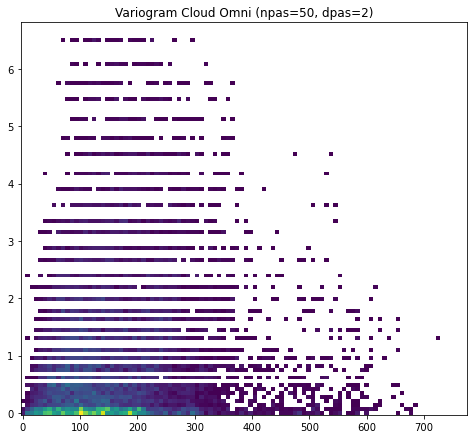

In [35]:
grid_cloud.plot("Cloud*")
plt.gca().set_aspect(100) # Grid mesh ratio
plt.title("Variogram Cloud Omni (npas=50, dpas=2)")
plt.show()


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 5
Maximum Number of UIDs       = 5
Total number of samples      = 10000

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :      7.789     0.042
Number :        100       100

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = Cloud.January_temp.1 - Locator = NA
Column = 4 - Name = Cloud.January_temp.2 - Locator = NA
 

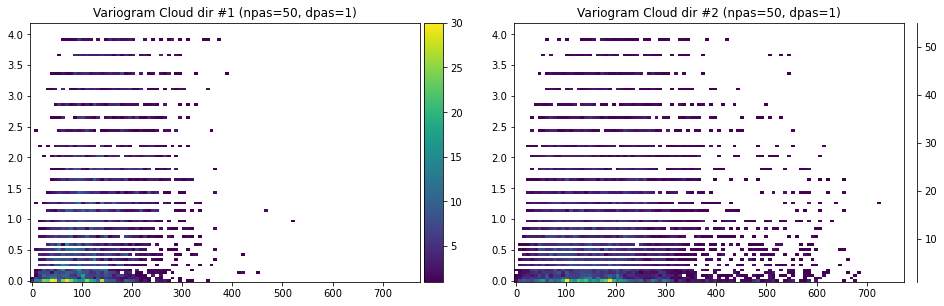

In [56]:
varioParamMulti = gl.VarioParam.createMultiple(2, 50, 1.)
grid_cloud2 = gl.db_variogram_cloud(dat, varioParamMulti)
grid_cloud2.display()
fig, ax = plt.subplots(1,2,figsize=[14,5])
fig.tight_layout(pad=4.0)
ax[0].raster(grid_cloud2, "Cloud.January_temp.1", flagLegend=True)
ax[0].decoration(title="Variogram Cloud dir #1 (npas=50, dpas=1)")
ax[1].raster(grid_cloud2, "Cloud.January_temp.2", flagLegend=True)
ax[1].decoration(title="Variogram Cloud dir #2 (npas=50, dpas=1)")
plt.gca().set_aspect(100) # Grid mesh ratio
plt.show()

<AxesSubplot:>

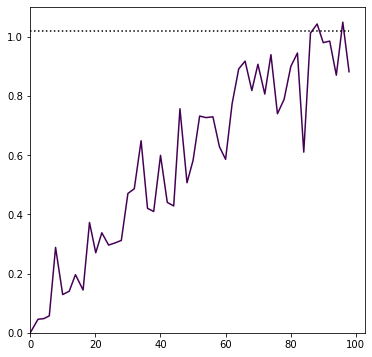

In [38]:
varioexp = gl.Vario(varioParamOmni, dat)
err = varioexp.compute()
gp.setDefault(dims=[6,6])
gp.varmod(varioexp)

### Experimental Variogram

We calculate the omni-directional variogram of the temperatures.

In [57]:
varioParamOmni = gl.VarioParam.createOmniDirection(40, 10)
varioexp = gl.Vario(varioParamOmni, dat)
err = varioexp.compute()

Print the variogram contents

In [58]:
varioexp


Variogram characteristics
Number of variable(s)       = 1
Number of direction(s)      = 1
Space dimension             = 2
Variance-Covariance Matrix     1.020

Direction #1
------------
Number of lags              = 40
Direction coefficients      =      1.000     0.000
Direction angles (degrees)  =      0.000     0.000
Tolerance on direction      =     90.000 (degrees)
Calculation lag             =     10.000
Tolerance on distance       =     50.000 (Percent of the lag value)

For variable 1
      Rank    Npairs  Distance     Value
         0    19.000     3.118     0.042
         1    89.000    10.690     0.172
         2   168.000    20.346     0.280
         3   244.000    30.323     0.456
         4   316.000    40.429     0.459
         5   385.000    50.162     0.660
         6   399.000    60.296     0.729
         7   463.000    70.062     0.874
         8   450.000    79.807     0.800
         9   473.000    90.115     0.977
        10   549.000   100.141     0.879
        11

Plot the omni-directional variogram

<AxesSubplot:>

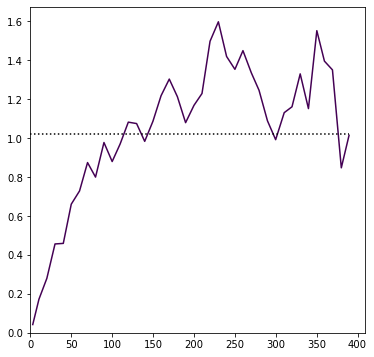

In [59]:
gp.setDefault(dims=[6,6])
gp.varmod(varioexp)

Represent the variogram with the number of pairs. By storing the *Axes* in a variable *ax* returned by the last instruction, we prevent jupyter from displaying '\<AxesSubplot:\>' before the plot.

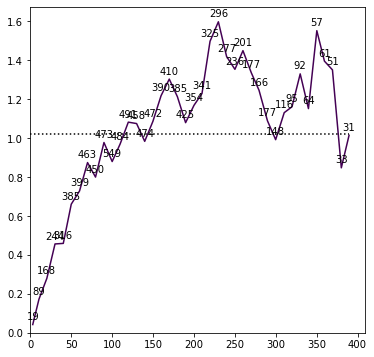

In [60]:
ax = gp.varmod(varioexp,show_pairs=True)

Automatic Fitting procedure (with default fitting parameters).

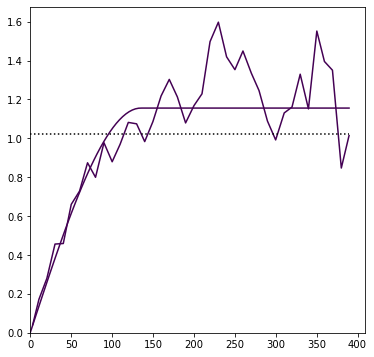

In [61]:
fitmod = gl.Model()
err = fitmod.fit(varioexp)
gp.varmod(varioexp, fitmod)
plt.show() # This last instruction also prevents jupyter from displaying a text before the plot

Print the Fittied Model content

In [62]:
fitmod


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 1
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Spherical
- Sill         =      1.155
- Range        =    135.117
Total Sill     =      1.155

List of Basic Covariances structures known by **gstlearn**

In [63]:
gl.ECov.printAll()

  -2 -     UNKNOWN : Unknown covariance
   -1 -    FUNCTION : External covariance function
    0 -      NUGGET : Nugget effect
    1 - EXPONENTIAL : Exponential
    2 -   SPHERICAL : Spherical
    3 -    GAUSSIAN : Gaussian
    4 -       CUBIC : Cubic
    5 -     SINCARD : Sine Cardinal
    6 -    BESSEL_J : Bessel J
    7 -    BESSEL_K : Bessel K
    8 -       GAMMA : Gamma
    9 -      CAUCHY : Cauchy
   10 -      STABLE : Stable
   11 -      LINEAR : Linear
   12 -       POWER : Power
   13 -   ORDER1_GC : First Order Generalized covariance
   14 -   SPLINE_GC : Spline Generalized covariance
   15 -   ORDER3_GC : Third Order Generalized covariance
   16 -   ORDER5_GC : Fifth Order Generalized covariance
   17 -     COSINUS : Cosine
   18 -    TRIANGLE : Triangle
   19 -      COSEXP : Cosine Exponential
   20 -       REG1D : 1-D Regular
   21 -       PENTA : Pentamodel
   22 -  SPLINE2_GC : Order-2 Spline
   23 -     STORKEY : Storkey covariance in 1-D
   24 -   WENDLAND0 : Wendland 

Automatic Fitting (using given basic structures)

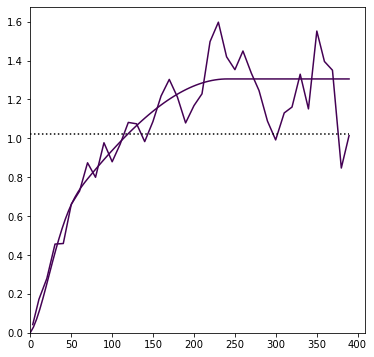

In [64]:
types = [gl.ECov.NUGGET, gl.ECov.CUBIC, gl.ECov.SPHERICAL]
err = fitmod.fit(varioexp, types=types)
ax = gp.varmod(varioexp, fitmod)

The resulting Model

In [65]:
fitmod


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 2
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Cubic
- Sill         =      0.413
- Range        =     75.995
Spherical
- Sill         =      0.893
- Range        =    240.635
Total Sill     =      1.305

Model Fitting with Inequality constraints


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 3
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Nugget Effect
- Sill         =      0.000
Cubic
- Sill         =      0.109
- Range        =     20.000
Spherical
- Sill         =      1.056
- Range        =    155.372
Total Sill     =      1.165
 

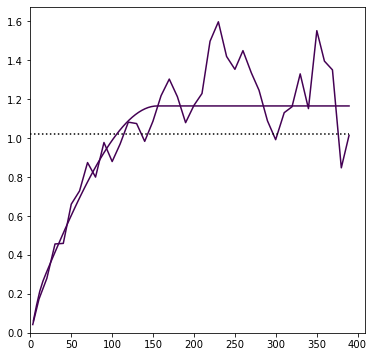

In [80]:
constraints = gl.Constraints()
err = constraints.addItemFromParamId(gl.EConsElem.RANGE,1,0,0,gl.EConsType.UPPER,20.)
err = constraints.addItemFromParamId(gl.EConsElem.SILL,1,0,0,gl.EConsType.LOWER,0.03)
err = fitmod.fit(varioexp, types, constraints, gl.Option_VarioFit(True))
fitmod.display()
ax = gp.varmod(varioexp, fitmod)

The resulting Model

In [ ]:
fitmod

Model Fitting with Equality constraints

In [ ]:
constraints = gl.Constraints()
err = constraints.addItemFromParamId(gl.EConsElem.RANGE,1,0,0,gl.EConsType.EQUAL,1000.)
err = constraints.addItemFromParamId(gl.EConsElem.SILL,1,0,0,gl.EConsType.EQUAL,0.4)
err = fitmod.fit(varioexp, types, constraints, gl.Option_VarioFit(True))
ax = gp.varmod(varioexp, fitmod)

The resulting Model

In [ ]:
fitmod

Directional Variograms

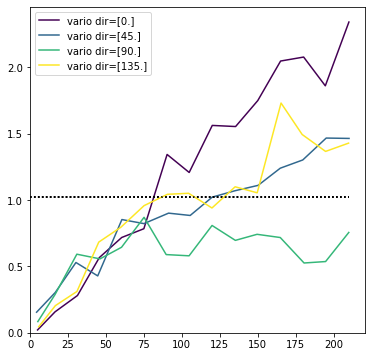

In [81]:
varioParamMulti = gl.VarioParam.createMultiple(4, 15, 15.)
vario_4dir = gl.Vario(varioParamMulti, dat)
err = vario_4dir.compute()
ax = gp.varmod(vario_4dir, flagLegend=True)


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 3
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Nugget Effect
- Sill         =      0.006
Cubic
- Sill         =      0.400
- Ranges       =    190.860  1000.000
- Angles       =    357.114     0.000
- Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.999     0.050
     [  1,]    -0.050     0.999
Spherical
- Sill         =      0.788
- Ranges       =    120.110    76.293
- Angles       =    359.009     0.000
- Rotation Matrix
               [,  0]    [,  1]
     [  0,]     1.000     0.017
     [  1,]    -0.017     1.000
Total Sill     =      1.194
 

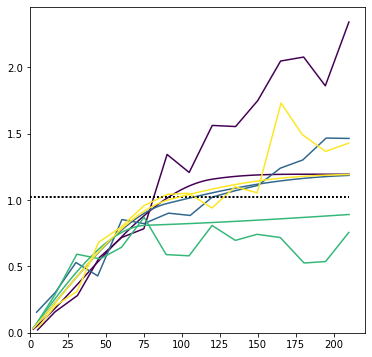

In [89]:
constraints = gl.Constraints()
err = constraints.addItemFromParamId(gl.EConsElem.RANGE,1,1,0,gl.EConsType.EQUAL,1000.)
err = constraints.addItemFromParamId(gl.EConsElem.SILL,1,type=gl.EConsType.EQUAL,value=0.4)
model_4dir = gl.Model()
err = model_4dir.fit(vario_4dir, types, constraints, gl.Option_VarioFit(True))
model_4dir.display()
ax = gp.varmod(vario_4dir, model_4dir)

Fitting a Multi-directional variogram

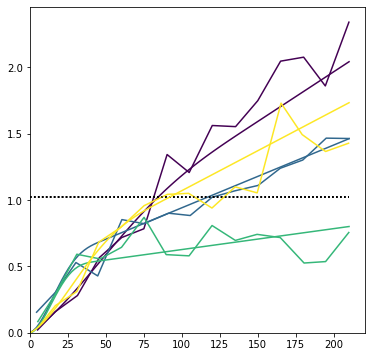

In [82]:
model_4dir = gl.Model()
err = model_4dir.fit(vario_4dir,types=types)
ax = gp.varmod(vario_4dir, model_4dir)

Calculating Variogram Map (the result is returned as a Grid data base displayed using *raster* function). At the right is displayed the number of pairs used for the variogram calculation in each grid cell.

In [ ]:
grid_vmap = gl.db_vmap_compute(dat, gl.ECalcVario.VARIOGRAM)
grid_vmap.display()
fig, ax = plt.subplots(1,2,figsize=[14,10])
fig.tight_layout(pad=5.0)
ax[0].raster(grid_vmap, flagLegend=True)
ax[1].raster(grid_vmap, name="*Nb", flagLegend=True)
plt.show()

Automatic Model Fitting from Variogram Map

In [ ]:
modelVM = gl.Model()
err = modelVM.fitFromVMap(grid_vmap, types=types)
modelVM

Drawing the Fitted Model as a Variogram Map

In [ ]:
err = gl.dbgrid_model(grid_vmap, modelVM)
grid_vmap.display()
ax = gp.raster(grid_vmap, flagLegend=True)

Compare Directional Variograms and fitted model from Variogram Map

In [ ]:
ax = gp.varmod(vario_4dir, modelVM)